In [1]:
import numpy as np
import dask
import xarray as xr
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=4, walltime='12:00:00')
w = cluster.scale(14*1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.147:39399 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 14 Cores: 14 Memory: 239.96 GB


__________________
# 1. Pi_omega

## Butterworth filter

In [23]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg_butter = xr.open_zarr(out_dir_store+'PI_cg_butter_5d.zarr')

out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

ds = xr.merge([PI_cg_butter,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
ds

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg       (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

In [24]:
# depth range: 50-500 m
# winter: Dec-Feb
# spring: Mar-May

winter = ds.PI_cg.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time'])
spring = ds.PI_cg.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time'])

winter.load()
spring.load()

<xarray.DataArray 'PI_cg' (lat: 197, lon: 173)>
array([[-1.27684796e-08, -1.36052103e-08, -1.68243197e-08, ...,
        -5.43385514e-09, -4.67973216e-09, -4.14712309e-09],
       [-1.41439349e-08, -1.50388093e-08, -1.73984738e-08, ...,
        -5.08134246e-09, -4.30309655e-09, -3.96628552e-09],
       [-1.44018628e-08, -1.64664176e-08, -1.79010549e-08, ...,
        -2.77064927e-09, -3.02429126e-09, -3.89337806e-09],
       ...,
       [-5.84387827e-09, -5.50900259e-09, -6.07031758e-09, ...,
        -1.19927390e-09, -1.33956424e-09, -1.73543835e-09],
       [-8.95390073e-09, -8.84702356e-09, -8.98581298e-09, ...,
        -2.85320434e-09, -3.22379723e-09, -3.62262820e-09],
       [-1.17219336e-08, -1.18220935e-08, -1.12917231e-08, ...,
        -3.91895894e-09, -5.47881163e-09, -6.12508444e-09]], dtype=float32)
Coordinates:
  * lat      (lat) float64 47.43 47.44 47.46 47.47 ... 49.92 49.94 49.95 49.96
  * lon      (lon) float64 -17.99 -17.97 -17.95 -17.93 ... -14.45 -14.43 -14.41

In [25]:
num_repeat = np.arange(10000)

In [92]:
for num in num_repeat:
    
    winter_sample = winter[np.random.choice(winter.shape[0], size=int(winter.shape[0]*0.5), replace=False),np.random.choice(winter.shape[1], size=int(winter.shape[1]*0.5), replace=False)]
    winter_inverse = winter_sample.where(winter_sample<0).count(dim=['lat','lon'])
    winter_total = winter_sample.count(dim=['lat','lon'])
    per = (winter_inverse/winter_total)
    pera[num] = per.values
    #print(pera)

In [26]:
pera_winter = np.empty([10000])

for num in num_repeat:
    
    winter_sample = winter[np.random.randint(winter.shape[0], size=int(winter.shape[0]*0.95)),np.random.randint(winter.shape[1], size=int(winter.shape[1]*0.95))]
    winter_inverse = winter_sample.where(winter_sample<0).count(dim=['lat','lon'])
    winter_total = winter_sample.count(dim=['lat','lon'])
    per = (winter_inverse/winter_total)
    pera_winter[num] = per.values
    #print(pera)

In [27]:
pera_spring = np.empty([10000])

for num in num_repeat:
    
    spring_sample = spring[np.random.randint(spring.shape[0], size=187),np.random.randint(spring.shape[1], size=161)]
    spring_inverse = spring_sample.where(spring_sample<0).count(dim=['lat','lon'])
    spring_total = spring_sample.count(dim=['lat','lon'])
    per = spring_inverse/spring_total
    pera_spring[num] = per.values
    #print(pera)

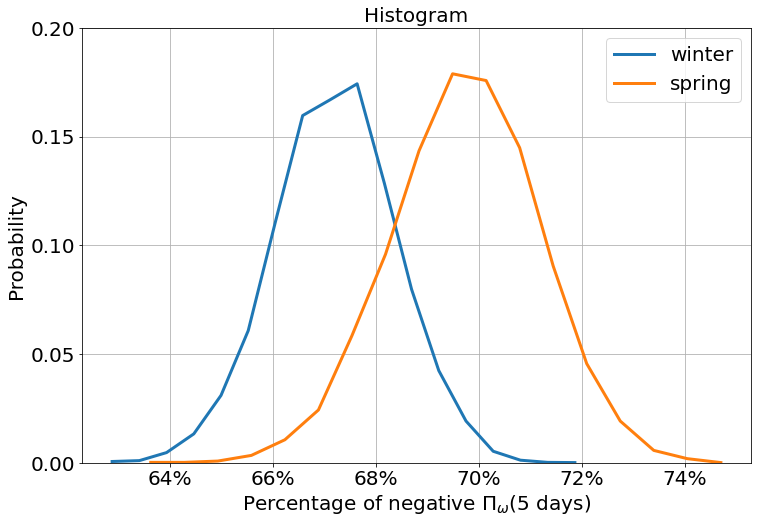

In [46]:
font_size=20
labels = ['winter','spring']

fig, ax = plt.subplots(figsize=(12,8))
ax = plt.subplot(111)

hist, edges = np.histogram(pera_winter,18)
plt.plot(0.5*(edges[1:]+edges[:-1]),hist/hist.sum(), label=labels[0], linewidth=3)

hist, edges = np.histogram(pera_spring,18)
plt.plot(0.5*(edges[1:]+edges[:-1]),hist/hist.sum(), label=labels[1], linewidth=3)

ax.set_ylabel('Probability',fontsize=font_size)
ax.set_xlabel('Percentage of negative $\Pi_{\omega}$(5 days)',fontsize=font_size)
ax.set_xticks([0.64,0.66,0.68,0.70,0.72,0.74])
ax.set_xticklabels(['64%','66%', '68%', '70%', '72%', '74%'])
ax.set_ylim([0, 0.20])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.set_title('Histogram',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()
ax.legend(); 
ax.legend(prop={'size': font_size})

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Bootstrap.png')

In [30]:
pera.mean()

0.6763236402765096

In [31]:
pera.std()

0.012992654985800435

In [32]:
pera_spring.mean()

0.6972658219018832

In [33]:
pera_spring.std()

0.014211466141845043

# xscale filter

In [21]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'

D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg.PI_cg_single

out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

ds = xr.merge([PI_cg_5d,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
ds

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: depth
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    mld_filter    (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

In [7]:
# depth range: 50-500 m
# winter: Dec-Feb
# spring: Mar-May

winter = ds.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time'])
spring = ds.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time'])

winter.load()
spring.load()

<xarray.DataArray 'PI_cg_single' (lat: 197, lon: 173)>
array([[-1.36883500e-08, -1.38144207e-08, -1.63176495e-08, ...,
        -6.38073461e-09, -5.37362643e-09, -4.55308458e-09],
       [-1.59235931e-08, -1.60973563e-08, -1.78893291e-08, ...,
        -6.28476382e-09, -5.40203038e-09, -5.02993736e-09],
       [-1.70926437e-08, -1.86133224e-08, -1.94703400e-08, ...,
        -4.00072597e-09, -4.07738243e-09, -5.12123099e-09],
       ...,
       [-7.89097676e-09, -8.29606428e-09, -9.91002036e-09, ...,
        -1.55499191e-09, -1.35429157e-09, -1.61021885e-09],
       [-1.08461187e-08, -1.11775780e-08, -1.21393908e-08, ...,
        -3.09109782e-09, -3.52197449e-09, -3.88197874e-09],
       [-1.35063765e-08, -1.39288261e-08, -1.41287853e-08, ...,
        -3.81913257e-09, -5.14050180e-09, -5.96657612e-09]], dtype=float32)
Coordinates:
  * lat      (lat) float64 47.43 47.44 47.46 47.47 ... 49.92 49.94 49.95 49.96
  * lon      (lon) float64 -17.99 -17.97 -17.95 -17.93 ... -14.45 -14.43 -14.41

In [9]:
num_repeat = np.arange(10000)

In [10]:
pera = np.empty([10000])

for num in num_repeat:
    
    winter_sample = winter[np.random.randint(winter.shape[0], size=int(winter.shape[0]*0.95)),np.random.randint(winter.shape[1], size=int(winter.shape[1]*0.95))]
    winter_inverse = winter_sample.where(winter_sample<0).count(dim=['lat','lon'])
    winter_total = winter_sample.count(dim=['lat','lon'])
    per = (winter_inverse/winter_total)
    pera[num] = per.values
    #print(pera)

In [11]:
pera_spring = np.empty([10000])

for num in num_repeat:
    
    spring_sample = spring[np.random.randint(spring.shape[0], size=187),np.random.randint(spring.shape[1], size=161)]
    spring_inverse = spring_sample.where(spring_sample<0).count(dim=['lat','lon'])
    spring_total = spring_sample.count(dim=['lat','lon'])
    per = spring_inverse/spring_total
    pera_spring[num] = per.values
    #print(pera)

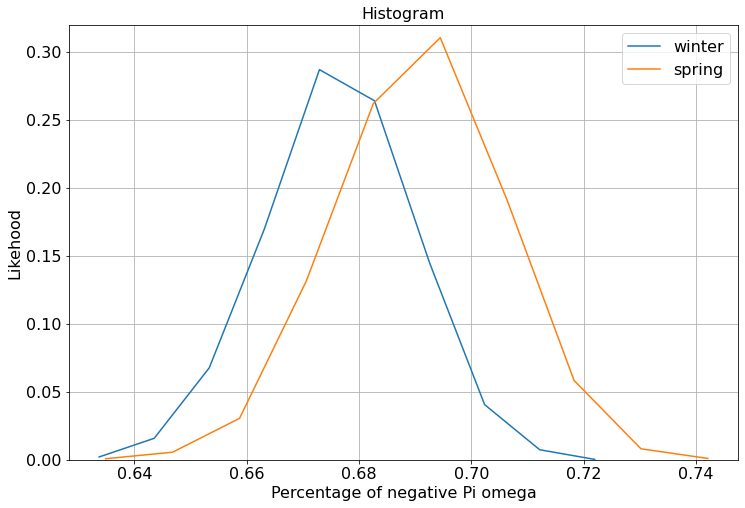

In [12]:
font_size=16
labels = ['winter','spring']

fig, ax = plt.subplots(figsize=(12,8))
ax = plt.subplot(111)

hist, edges = np.histogram(pera,10)
plt.plot(0.5*(edges[1:]+edges[:-1]), hist/hist.sum(), label=labels[0])

hist, edges = np.histogram(pera_spring,10)
plt.plot(0.5*(edges[1:]+edges[:-1]), hist/hist.sum(), label=labels[1])

ax.set_ylabel('Likehood',fontsize=font_size)
ax.set_xlabel('Percentage of negative Pi omega',fontsize=font_size)
#ax.set_xticks([-18,-17,-16,-15])
#ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
ax.set_ylim([0, 0.32])
ax.set_title('Histogram',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()
ax.legend(); 
ax.legend(prop={'size': font_size})



In [13]:
pera.mean()

0.6763236402765096

In [14]:
pera.std()

0.012992654985800435

In [15]:
pera_spring.mean()

0.6908141063540041

In [16]:
pera_spring.std()

0.014631350991109064

In [49]:
cluster.close()